In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

# Table of Content:

[1. Introduction](#1)

[2. Data Overview](#2)

[3. Basic Model Fitting](#3)
* [3.1 Model evaluation](#3.1) 

[4. Models With Resampling](#4)
* [4.1 Downsample](#4.1)
* [4.2 Upsample](#4.2)
* [4.3 Class weight for Random Forest (Manually)](#4.3)
    * [4.31 Balanced Class for RF and DecisionTree](#4.31)    
* [4.4 Smote](#4.4)

[5. Precision vs. Recall curve](#5)

[6. Final Test](#6)

<a id="1"></a>
# 1. Introduction

### Goal: the pros and cons of different techniques for handling inbalanced dataset

### Variables: 
* Churn: 1 if customer cancelled service, 0 if not
* AccountWeeks: number of weeks customer has had active account
* ContractRenewal: 1 if customer recently renewed contract, 0 if not
* DataPlan: 1 if customer has data plan, 0 if not
* DataUsage: gigabytes of monthly data usage
* CustServCalls: number of calls into customer service
* DayMins: average daytime minutes per month
* DayCalls: average number of daytime calls
* MonthlyCharge: average monthly bill
* OverageFee: largest overage fee in last 12 months
* RoamMins: average number of roaming minutes

<a id="2"></a>
# 2. Data Overview

In [2]:
#Load the data
df = pd.read_csv("/kaggle/input/telecom-churn/telecom_churn.csv")
df.sample(5)

FileNotFoundError: [Errno 2] File /kaggle/input/telecom-churn/telecom_churn.csv does not exist: '/kaggle/input/telecom-churn/telecom_churn.csv'

In [4]:
#check missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 11 columns):
Churn              3333 non-null int64
AccountWeeks       3333 non-null int64
ContractRenewal    3333 non-null int64
DataPlan           3333 non-null int64
DataUsage          3333 non-null float64
CustServCalls      3333 non-null int64
DayMins            3333 non-null float64
DayCalls           3333 non-null int64
MonthlyCharge      3333 non-null float64
OverageFee         3333 non-null float64
RoamMins           3333 non-null float64
dtypes: float64(5), int64(6)
memory usage: 286.6 KB


- No missing Data - Great!
- No Categorical variables - Great!

Ambigious varaible: Customer Service Call 
1. I wonder if the customer service call is the average numbers of call/month, or the most recent month's call or the total amount of calls that customer have made. 
2. We don't have any ideas on when the calls were made. 5 recent customers service calls can be an indicator to predict the churn, while 5 customer service calls that were made a year ago will not be an indicator


### Baseline Churn

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math

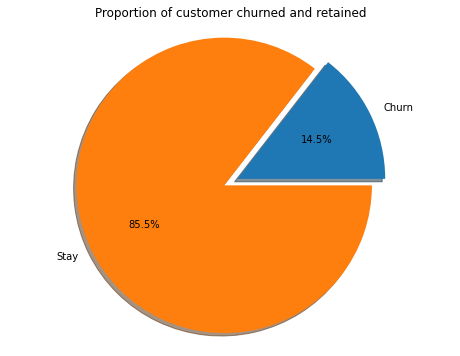

In [6]:
#default churn rate
labels = 'Churn', "Stay"
sizes = [df.Churn[df['Churn'] == 1].count(), df.Churn[df['Churn'] == 0].count()]
explode = (0.1, 0)

fig1, ax1 = plt.subplots(figsize=(8, 6))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True)
ax1.axis('equal')

plt.title("Proportion of customer churned and retained")

plt.show()

<a id="3"></a>
# 3. Model fitting with original data

In [7]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.model_selection import cross_val_score

from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve, auc, roc_curve

In [8]:
#dat preperation
label = df["Churn"]
df_train1 = df.iloc[:, 1:].copy()
feature_names = list(df_train1.columns.values)

#I seperate the data into train, valiation and test. We will reserve the test set till the end to test the performance of the best model.

#set, testset
X_trainval, X_test, y_trainval, y_test = train_test_split(df_train1, label, test_size = 0.2, random_state=1)
#train, validation set split
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size = 0.2, random_state=1)

### Baseline Model

In [9]:
#dummy model
dummy1 = DummyClassifier(random_state=1).fit(X_train, y_train)
pred_dummy1 = dummy1.predict(X_val)
print("randomly guessing score: {:.2f}".format(dummy1.score(X_val,y_val)))
dummy2 = DummyClassifier(strategy = 'most_frequent').fit(X_train, y_train)
pred_dummy2 = dummy2.predict(X_val)
print("guess all customers will stay score: {:.2f}".format(dummy2.score(X_val,y_val)))

randomly guessing score: 0.73
guess all customers will stay score: 0.85


/opt/conda/lib/python3.6/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


### Different Tree models

In [10]:
#tree model
tree = DecisionTreeClassifier(random_state=1).fit(X_train, y_train)
print("Decision Tree validation score: {:.2f}".format(tree.score(X_val, y_val)))
tree_crossval = cross_val_score(tree, X_trainval, y_trainval)
print("Decision Tree cross-validation score: {:.2f}".format(tree_crossval.mean()))

#tree model with simple tune
tree_tune = DecisionTreeClassifier(random_state=1, max_depth = 6).fit(X_train, y_train)
#I picked 6 by just trying out different numbers. We can also use GridSearchCV to select the best parameters but I am a bit lazy to do so. 
print("Decision Tree validation score after tune: {:.2f}".format(tree_tune.score(X_val, y_val)))
pred_tree = tree.predict(X_val)
tree_crossval_tune = cross_val_score(tree_tune, X_trainval, y_trainval)
print("Decision Tree cross-validation score (tune): {:.2f}".format(tree_crossval_tune.mean()))

Decision Tree validation score: 0.90
Decision Tree cross-validation score: 0.89
Decision Tree validation score after tune: 0.92
Decision Tree cross-validation score (tune): 0.92


In [11]:
print("With original dataset")
#tree model with simple tune
tree_tune = DecisionTreeClassifier(random_state=1, max_depth = 6).fit(X_train, y_train)
#I picked 6 by just trying out different numbers. We can also use GridSearchCV to select the best parameters but I am a bit lazy to do so. 
print("Decision Tree (max_depth 6) validation score: {:.2f}".format(tree_tune.score(X_val, y_val)))
pred_tree = tree.predict(X_val)
tree_crossval_tune = cross_val_score(tree_tune, X_trainval, y_trainval)
print("Decision Tree (max_depth 6) cross-validation score max_depth 6: {:.2f}".format(tree_crossval_tune.mean()))

#random forest model
forest = RandomForestClassifier(random_state=1, max_depth=8).fit(X_train, y_train)
pred_forest = forest.predict(X_val)
print("\nRandom Forest (max_depth 8) validation score: {:.2f}".format(forest.score(X_val, y_val)))
forest_crossval = cross_val_score(forest, X_trainval, y_trainval)
print("Random Forest (max_depth 8) cross-validation score: {:.2f}".format(forest_crossval.mean()))

#Gradient Boosting model
gradient = GradientBoostingClassifier(random_state=1).fit(X_train, y_train)
pred_gradient = gradient.predict(X_val)
#print("Gradient Boosting train score: {:.2f}".format(gradient.score(X_train, y_train)))
print("\nGradient Boosting validation score: {:.2f}".format(gradient.score(X_val, y_val)))
gradient_crossval = cross_val_score(gradient, X_trainval, y_trainval)
print("Grandient Boosting cross-validation score: {:.2f}".format(gradient_crossval.mean()))

#XG bossting model
xg = XGBClassifier().fit(X_train, y_train)
pred_xg = xg.predict(X_val)
#print("XGBoost train score: {:.2f}".format(xg.score(X_train, y_train)))
print("\nXGBoost validation score: {:.2f}".format(xg.score(X_val, y_val)))
xg_crossval = cross_val_score(xg, X_trainval, y_trainval)
print("XGBoost cross-validation score: {:.2f}".format(xg_crossval.mean()))

With original dataset
Decision Tree (max_depth 6) validation score: 0.92
Decision Tree (max_depth 6) cross-validation score max_depth 6: 0.92

Random Forest (max_depth 8) validation score: 0.93
Random Forest (max_depth 8) cross-validation score: 0.94

Gradient Boosting validation score: 0.93
Grandient Boosting cross-validation score: 0.93

XGBoost validation score: 0.92
XGBoost cross-validation score: 0.93


<a id="3.1"></a>
# 3.1 Basic model Evaluation

In [12]:
print("With original dataset")
#confusion matrix for dummy
confusion_dummy = confusion_matrix(y_val, pred_dummy2)
print("confusion matrix for dummy model:\n{}".format(confusion_dummy))

#confusion matrix for trees 
confusion_tree=confusion_matrix(y_val, pred_tree)
print("confusion matrix for decision tree (max_depth 6):\n{}".format(confusion_tree))

confusion_forest=confusion_matrix(y_val, pred_forest)
print("confusion matrix for random forest (max_depth 8):\n{}".format(confusion_forest))

confusion_gradient=confusion_matrix(y_val, pred_gradient)
print("confusion matrix for gradient boost:\n{}".format(confusion_gradient))

confusion_xg=confusion_matrix(y_val, pred_xg)
print("confusion matrix for xg boosting:\n{}".format(confusion_xg))

With original dataset
confusion matrix for dummy model:
[[452   0]
 [ 82   0]]
confusion matrix for decision tree (max_depth 6):
[[428  24]
 [ 32  50]]
confusion matrix for random forest (max_depth 8):
[[445   7]
 [ 30  52]]
confusion matrix for gradient boost:
[[444   8]
 [ 28  54]]
confusion matrix for xg boosting:
[[438  14]
 [ 29  53]]


Based on the confusion matrix, the our RF model makes more False Negative mistakes, which means customers will churn but the model says it will stay. It is because we have so many "Stay" in the sample that the model is focusing on getting the "Stay" class right, not the "Churn" class. We will need to rebalance the dataset. 

In [13]:
#classification_report
#dummy
print("dummy classificatoin report\n")
print(classification_report(y_val, pred_dummy2, target_names = ["Stay", "Churn"]))
print("\nrandom forest classification report\n")
print(classification_report(y_val, pred_forest, target_names = ["Stay", "Churn"]))

dummy classificatoin report

              precision    recall  f1-score   support

        Stay       0.85      1.00      0.92       452
       Churn       0.00      0.00      0.00        82

    accuracy                           0.85       534
   macro avg       0.42      0.50      0.46       534
weighted avg       0.72      0.85      0.78       534


random forest classification report

              precision    recall  f1-score   support

        Stay       0.94      0.98      0.96       452
       Churn       0.88      0.63      0.74        82

    accuracy                           0.93       534
   macro avg       0.91      0.81      0.85       534
weighted avg       0.93      0.93      0.93       534



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


From the classification report aboved, the difference between the model's ability to predict "Stay" vs. to predict "Churn is even more obvious. Here are some reminders what "precision" and "recall" are:
* Precision: True Positive / (True Positive + False Positive). Let's translate to Englis and let's use the example of "Churn", which is 0.88. It means: The times the model rightly predicted customers will churn / (rightly predict churn + predict churn but the client stay) is 88% 
* Recall: True Positive / (True Positive + False Negative). Let's translate to Englis and let's use the example of "Churn", which is 0.63. It means: The times the model rightly predicted customers will churn / (rightly predict churn + predict stay but the client churn) is 63% 

<a id="4"></a>
# 4. Models With Resamplings

<a id="4.1"></a>
### 4.1 Downsample

In [14]:
from sklearn.utils import resample

In [15]:
# Separate majority and minority classes
df_maj = df[df.Churn==0]
df_min = df[df.Churn==1]

print("The minority sample size is: {}".format(len(df_min))) #483

# Downsample majority class
df_maj_ds = resample(df_maj, replace=False,    # sample without replacement
                             n_samples=483,     # to match minority class
                             random_state=1) # reproducible results
# Combine minority class with downsampled majority class
df_ds = pd.concat([df_maj_ds, df_min])
 
# Display new class counts
df_ds.Churn.value_counts()


The minority sample size is: 483


1    483
0    483
Name: Churn, dtype: int64

In [16]:
#dat preperation
label2 = df_ds["Churn"]
df_ds_train = df_ds.iloc[:, 1:].copy()
feature_names2 = list(df_ds_train.columns.values)
#set, testset split
Xds_train, Xds_val, yds_train, yds_val = train_test_split(df_ds_train, label2, test_size = 0.2, random_state=1)

In [17]:
print("Downsampling")
#tree after downsample
tree_ds = DecisionTreeClassifier(random_state=1, max_depth = 4).fit(Xds_train, yds_train)
print("Tree (max_depth 4) validation score: {:.2f}".format(tree_ds.score(X_val, y_val)))
tree_ds_crossval = cross_val_score(tree_ds, X_val, y_val)
print("Tree (max_depth 4) cross-validation score after ds: {:.2f}".format(tree_ds_crossval.mean()))

#random forest model after downsampled
forest_ds = RandomForestClassifier(random_state=1).fit(Xds_train, yds_train)
print("\nRandom Forest validation score: {:.2f}".format(forest_ds.score(X_val, y_val)))
forest_ds_crossval = cross_val_score(forest_ds, X_val, y_val)
print("Random Forest cross-validation score after ds: {:.2f}".format(forest_ds_crossval.mean()))

gradient_ds = GradientBoostingClassifier(random_state=1).fit(Xds_train, yds_train)
print("\nGradient Boosting validation score: {:.2f}".format(gradient_ds.score(X_val, y_val)))
gradient_ds_crossval = cross_val_score(gradient_ds, X_val, y_val)
print("Gradient Boosting cross-validation score after ds: {:.2f}".format(gradient_ds_crossval.mean()))

xg_ds = XGBClassifier(random_state=1).fit(Xds_train, yds_train)
print("\nXG Boosting validation score: {:.2f}".format(xg_ds.score(X_val, y_val)))
xg_ds_crossval = cross_val_score(xg_ds, X_val, y_val)
print("XG Boosting cross-validation score after ds: {:.2f}".format(xg_ds_crossval.mean()))

Downsampling
Tree (max_depth 4) validation score: 0.84
Tree (max_depth 4) cross-validation score after ds: 0.90

Random Forest validation score: 0.93
Random Forest cross-validation score after ds: 0.92

Gradient Boosting validation score: 0.91
Gradient Boosting cross-validation score after ds: 0.91

XG Boosting validation score: 0.89
XG Boosting cross-validation score after ds: 0.91


In [18]:
#confusion matrix for random forest downsampled
pred_tree_ds = tree_ds.predict(X_val)
confusion_tree_ds=confusion_matrix(y_val, pred_tree_ds)
print("\nconfusion matrix for tree(max_depth 4) after downsampling:\n{}".format(confusion_tree_ds))

pred_forest_ds = forest_ds.predict(X_val)
confusion_forest_ds=confusion_matrix(y_val, pred_forest_ds)
print("\nconfusion matrix for random forest after downsampling:\n{}".format(confusion_forest_ds))

pred_gradient_ds = gradient_ds.predict(X_val)
confusion_gradient_ds=confusion_matrix(y_val, pred_gradient_ds)
print("\nconfusion matrix for gradient boosting after downsampling:\n{}".format(confusion_gradient_ds))

pred_xg_ds = xg_ds.predict(X_val)
confusion_xg_ds=confusion_matrix(y_val, pred_xg_ds)
print("\nconfusion matrix for xg boosting after downsampling:\n{}".format(confusion_xg_ds))


confusion matrix for tree(max_depth 4) after downsampling:
[[381  71]
 [ 12  70]]

confusion matrix for random forest after downsampling:
[[414  38]
 [  2  80]]

confusion matrix for gradient boosting after downsampling:
[[412  40]
 [  6  76]]

confusion matrix for xg boosting after downsampling:
[[395  57]
 [  2  80]]


False positive performance all improved but we also sacrificed for predicting class "1" due to the loss of information

<a id="4.2"></a>
### 4.2 Upsample 

In [19]:
df_train = X_train.copy()

In [20]:
df_train["Churn"] = y_train

In [21]:
# Separate majority and minority classes
df_maj2 = df_train[df_train.Churn==0]
df_min2 = df_train[df_train.Churn==1]

print("The majority sample size is: {}".format(len(df_maj2))) #1829


# Upsample majority class
df_min_up = resample(df_min2, replace=True,    # sample without replacement
                             n_samples=1829,     # to match minority class
                             random_state=1) # reproducible results

# Combine minority class with downsampled majority class
df_up = pd.concat([df_min_up, df_maj2])
 
# Display new class counts
df_up.Churn.value_counts()

The majority sample size is: 1829


1    1829
0    1829
Name: Churn, dtype: int64

In [22]:
Xup_train = df_up.iloc[:, :-1].copy()

yup_train = df_up["Churn"]

In [23]:
tree_up = DecisionTreeClassifier(random_state=1, max_depth = 4).fit(Xup_train, yup_train)
print("Tree(max_depth 4) validation score after ups: {:.2f}".format(tree_up.score(X_val, y_val)))
tree_up_crossval = cross_val_score(tree_up, X_val, y_val)
print("Tree(max_depth 4) cross-validation score ups: {:.2f}".format(tree_up_crossval.mean()))

forest_up = RandomForestClassifier(random_state=1).fit(Xup_train, yup_train)
print("\nRandom Forest validation score after ups: {:.2f}".format(forest_up.score(X_val, y_val)))
forest_up_crossval = cross_val_score(forest_up, X_val, y_val)
print("Random Forest cross-validation score after ups: {:.2f}".format(forest_up_crossval.mean()))

gradient_up = GradientBoostingClassifier(random_state=1).fit(Xup_train, yup_train)
print("\nGradient Boosting validation score after ups: {:.2f}".format(gradient_up.score(X_val, y_val)))
gradient_up_crossval = cross_val_score(gradient_up, X_val, y_val)
print("Gradient Boosting cross-validation score: {:.2f}".format(gradient_up_crossval.mean()))

xg_up = XGBClassifier(random_state=1).fit(Xup_train, yup_train)
print("\nXG Boosting validation score after ups: {:.2f}".format(xg_up.score(X_val, y_val)))
xg_up_crossval = cross_val_score(xg_up, X_val, y_val)
print("XG Boosting cross-validation score: {:.2f}".format(xg_up_crossval.mean()))


Tree(max_depth 4) validation score after ups: 0.90
Tree(max_depth 4) cross-validation score ups: 0.90

Random Forest validation score after ups: 0.93
Random Forest cross-validation score after ups: 0.92

Gradient Boosting validation score after ups: 0.92
Gradient Boosting cross-validation score: 0.91

XG Boosting validation score after ups: 0.92
XG Boosting cross-validation score: 0.91


In [24]:
pred_tree_up = tree_up.predict(X_val)
confusion_tree_up=confusion_matrix(y_val, pred_tree_up)
print("\nconfusion matrix for tree(max_depth 4) after upsamling:\n{}".format(confusion_tree_up))

pred_forest_up = forest_up.predict(X_val)
confusion_forest_up=confusion_matrix(y_val, pred_forest_up)
print("\nconfusion matrix for random forest after upsamling:\n{}".format(confusion_forest_up))

pred_gradient_up = gradient_up.predict(X_val)
confusion_gradient_up=confusion_matrix(y_val, pred_gradient_up)
print("\nconfusion matrix for gradient after upsamling:\n{}".format(confusion_gradient_up))

pred_xg_up = xg_up.predict(X_val)
confusion_xg_up=confusion_matrix(y_val, pred_xg_up)
print("\nconfusion matrix for xg after upsamling:\n{}".format(confusion_xg_up))


confusion matrix for tree(max_depth 4) after upsamling:
[[420  32]
 [ 21  61]]

confusion matrix for random forest after upsamling:
[[437  15]
 [ 22  60]]

confusion matrix for gradient after upsamling:
[[422  30]
 [ 14  68]]

confusion matrix for xg after upsamling:
[[434  18]
 [ 23  59]]


By keep copying the data in small sample size, it overfit those data point. That's why for testing, the False Positive rate is still high

<a id="4.3"></a>
### 4.3 Manually changing the weights for RF

In [25]:
RF5 = RandomForestClassifier(class_weight={0: 1, 1: 5}, max_depth=4, random_state=1) #change the weight of class 1 to be 5 times bigger
rf_weighted = RF5.fit(X_train, y_train)
print("Random Forest(max_depth 4) validation score after weighted 1:5: {:.2f}".format(rf_weighted.score(X_val, y_val)))
rf_weighted_crossval = cross_val_score(rf_weighted, X_val, y_val)
print("Random Forest(max_depth 4) cross-validation score after weighted 1:5: {:.2f}".format(rf_weighted_crossval.mean()))

pred_rf_weighted = rf_weighted.predict(X_val)
confusion_rf_weighted=confusion_matrix(y_val, pred_rf_weighted)
print("\nconfusion matrix for random forest (max_depth 4) after weighted 1:5:\n{}".format(confusion_rf_weighted))

print("\n classification report for weights 1:5")
print(classification_report(y_val, pred_rf_weighted, target_names = ["Stay", "Churn"]))

Random Forest(max_depth 4) validation score after weighted 1:5: 0.93
Random Forest(max_depth 4) cross-validation score after weighted 1:5: 0.90

confusion matrix for random forest (max_depth 4) after weighted 1:5:
[[428  24]
 [ 12  70]]

 classification report for weights 1:5
              precision    recall  f1-score   support

        Stay       0.97      0.95      0.96       452
       Churn       0.74      0.85      0.80        82

    accuracy                           0.93       534
   macro avg       0.86      0.90      0.88       534
weighted avg       0.94      0.93      0.93       534



In [26]:
RF50 = RandomForestClassifier(class_weight={0: 1, 1: 50}, max_depth=4) #change it to be 50 times
rf_weighted2 = RF50.fit(X_train, y_train)

pred_rf_weighted2 = rf_weighted2.predict(X_val)
confusion_rf_weighted2=confusion_matrix(y_val, pred_rf_weighted2)
print("\nconfusion matrix for random forest(max_depth 4) after weighted 1:50:\n{}".format(confusion_rf_weighted2))

print("\nclassification report for weights 1:50")
print(classification_report(y_val, pred_rf_weighted2, target_names = ["Stay", "Churn"]))


confusion matrix for random forest(max_depth 4) after weighted 1:50:
[[ 14 438]
 [  0  82]]

classification report for weights 1:50
              precision    recall  f1-score   support

        Stay       1.00      0.03      0.06       452
       Churn       0.16      1.00      0.27        82

    accuracy                           0.18       534
   macro avg       0.58      0.52      0.17       534
weighted avg       0.87      0.18      0.09       534



<a id="4.31"></a>
### 4.3.1 balanced class_weight for RF and Tree

In [27]:
RFauto = RandomForestClassifier(class_weight='balanced', random_state = 1, max_depth=8)

rf_auto = RFauto.fit(X_train, y_train)
print("Random Forest(max_depth 8) validation score after balanced: {:.2f}".format(rf_auto.score(X_val, y_val)))
rfauto_crossval = cross_val_score(rf_auto, X_val, y_val)
print("Random Forest(max_depth 8) cross-validation score after balanced: {:.2f}".format(rfauto_crossval.mean()))

tree_auto = DecisionTreeClassifier(random_state=1, class_weight = 'balanced', max_depth=6).fit(X_train, y_train)
print("\nDecision Tree(max_depth 6) validation score after balanced: {:.2f}".format(tree_auto.score(X_val, y_val)))
treeauto_crossval = cross_val_score(tree_auto, X_trainval, y_trainval)
print("Decision Tree(max_depth 6) cross-validation after balanced: {:.2f}".format(treeauto_crossval.mean()))

Random Forest(max_depth 8) validation score after balanced: 0.93
Random Forest(max_depth 8) cross-validation score after balanced: 0.91

Decision Tree(max_depth 6) validation score after balanced: 0.90
Decision Tree(max_depth 6) cross-validation after balanced: 0.90


In [28]:

pred_rfauto = rf_auto.predict(X_val)
confusion_rfauto=confusion_matrix(y_val, pred_rfauto)
print("\nconfusion matrix for random forest(max_depth 8) after balanced:\n{}".format(confusion_rfauto))

#print("\nclassification report for random forest balanced classes")
#print(classification_report(y_val, pred_rfauto, target_names = ["Stay", "Churn"]))

pred_treeauto = tree_auto.predict(X_val)
confusion_treeauto=confusion_matrix(y_val, pred_treeauto)
print("\nconfusion matrix for tree(max_depth 6) after balanced classes:\n{}".format(confusion_treeauto))


confusion matrix for random forest(max_depth 8) after balanced:
[[436  16]
 [ 20  62]]

confusion matrix for tree(max_depth 6) after balanced classes:
[[413  39]
 [ 17  65]]


<a id="4.4"></a>
### 4.4 SMOTE


In [29]:
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

Using TensorFlow backend.


In [30]:
sm = SMOTE(sampling_strategy='auto', k_neighbors=2, random_state=1)
Xsm_train, ysm_train = sm.fit_resample(X_train, y_train)

In [31]:
#tree after smote
tree_sm = DecisionTreeClassifier(random_state=1, max_depth = 5).fit(Xsm_train, ysm_train)
print("Tree(max_depth 5) validation score after smote: {:.2f}".format(tree_up.score(X_val, y_val)))
tree_sm_crossval = cross_val_score(tree_sm, X_val, y_val)
print("Tree(max_depth 5) cross-validation score after smote: {:.2f}".format(tree_up_crossval.mean()))

#random forest model after downsampled
forest_sm = RandomForestClassifier(random_state=1, max_depth=8).fit(Xsm_train, ysm_train)
print("\nRandom Forest(max_depth 8) validation score after smote: {:.2f}".format(forest_sm.score(X_val, y_val)))
forest_sm_crossval = cross_val_score(forest_sm, X_val, y_val)
print("Random Forest(max_depth 8) cross-validation score after smote: {:.2f}".format(forest_sm_crossval.mean()))

gradient_sm = GradientBoostingClassifier(random_state=1).fit(Xsm_train, ysm_train)
print("\nGradient Boosting validation score after smote: {:.2f}".format(gradient_up.score(X_val, y_val)))
gradient_sm_crossval = cross_val_score(gradient_sm, X_val, y_val)
print("Gradient Boosting cross-validation score after smote: {:.2f}".format(gradient_sm_crossval.mean()))

xg_sm = XGBClassifier(random_state=1).fit(Xsm_train, ysm_train)
print("\nXG Boosting validation score after smote: {:.2f}".format(xg_sm.score(X_val, y_val)))
xg_sm_crossval = cross_val_score(xg_sm, X_val, y_val)
print("XG Boosting cross-validation score after smote: {:.2f}".format(xg_sm_crossval.mean()))

Tree(max_depth 5) validation score after smote: 0.90
Tree(max_depth 5) cross-validation score after smote: 0.90

Random Forest(max_depth 8) validation score after smote: 0.92
Random Forest(max_depth 8) cross-validation score after smote: 0.92

Gradient Boosting validation score after smote: 0.92
Gradient Boosting cross-validation score after smote: 0.91

XG Boosting validation score after smote: 0.92
XG Boosting cross-validation score after smote: 0.91


In [32]:
print("SMOTE")
pred_tree_sm = tree_sm.predict(X_val)
confusion_tree_sm=confusion_matrix(y_val, pred_tree_sm)
print("\nconfusion matrix for tree(max_depth 5) :\n{}".format(confusion_tree_sm))

pred_forest_sm = forest_sm.predict(X_val)
confusion_forest_sm=confusion_matrix(y_val, pred_forest_sm)
print("\nconfusion matrix for forest(max_depth 8) :\n{}".format(confusion_forest_sm))

pred_gradient_sm = gradient_sm.predict(X_val)
confusion_gradient_sm=confusion_matrix(y_val, pred_gradient_sm)
print("\nconfusion matrix for gradient:\n{}".format(confusion_gradient_sm))

pred_xg_sm = xg_sm.predict(X_val)
confusion_xg_sm=confusion_matrix(y_val, pred_xg_sm)
print("\nconfusion matrix for xg:\n{}".format(confusion_xg_sm))

SMOTE

confusion matrix for tree(max_depth 5) :
[[424  28]
 [ 12  70]]

confusion matrix for forest(max_depth 8) :
[[424  28]
 [ 15  67]]

confusion matrix for gradient:
[[419  33]
 [ 14  68]]

confusion matrix for xg:
[[429  23]
 [ 22  60]]


Performance for gradient and xg are very consistent. It's due to how their algorithms were designed. For the other tree methods, you can see the False positive rate improved a lot compare to when we used upsample. 

<a id="5"></a>
# 5. precision vs. recall curve

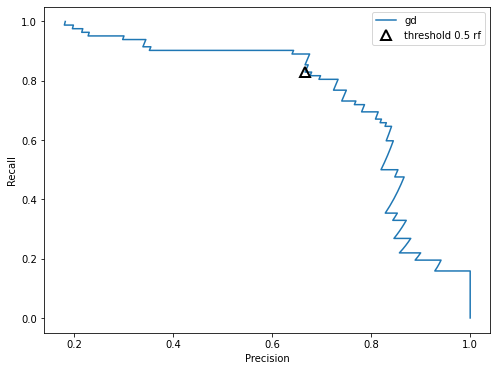

In [33]:
fig= plt.subplots(figsize=(8, 6))
precision_gd, recall_gd, thresholds_gd = precision_recall_curve(y_val, gradient_sm.predict_proba(X_val)[:, 1])
plt.plot(precision_gd, recall_gd, label="gd")

close_default_gd = np.argmin(np.abs(thresholds_gd - 0.5))
plt.plot(precision_gd[close_default_gd], recall_gd[close_default_gd], '^', c='k', markersize=10, label='threshold 0.5 rf', fillstyle="none", mew=2)
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.legend(loc="best")

Looks like we can maintain the same recall rate and improve the overall accuracy with an adjustment of the rate of threshold.

In [34]:
threshold = 0.38 #after different trails, this is the best

predicted_proba = gradient_sm.predict_proba(X_val)
predicted = (predicted_proba [:,1] >= threshold).astype('int')

#compare the accuracy scores
accuracy_adj = accuracy_score(y_val, predicted)
print("accurcy rate with 0.38 threshold {}".format(str(round(accuracy_adj,4,)*100))+"%")

accuracy = accuracy_score(y_val, pred_gradient_sm)
print("accurcy rate with 0.5 threshold {}".format(str(round(accuracy,4,)*100))+"%")

#confusion matrix compare
confusion_gd=confusion_matrix(y_val, predicted)
print("confusion matrix with new threshold:\n{}".format(confusion_gd))

pred_gradient_sm = gradient_sm.predict(X_val)
confusion_gd_sm=confusion_matrix(y_val, pred_gradient_sm)
print("\nconfusion matrix original:\n{}".format(confusion_gd_sm))

#classification_report
print("\nrandom forest classification report with adjuested threshold\n")
print(classification_report(y_val, predicted, target_names = ["Stay", "Churn"]))

accurcy rate with 0.38 threshold 91.75999999999999%
accurcy rate with 0.5 threshold 91.2%
confusion matrix with new threshold:
[[417  35]
 [  9  73]]

confusion matrix original:
[[419  33]
 [ 14  68]]

random forest classification report with adjuested threshold

              precision    recall  f1-score   support

        Stay       0.98      0.92      0.95       452
       Churn       0.68      0.89      0.77        82

    accuracy                           0.92       534
   macro avg       0.83      0.91      0.86       534
weighted avg       0.93      0.92      0.92       534



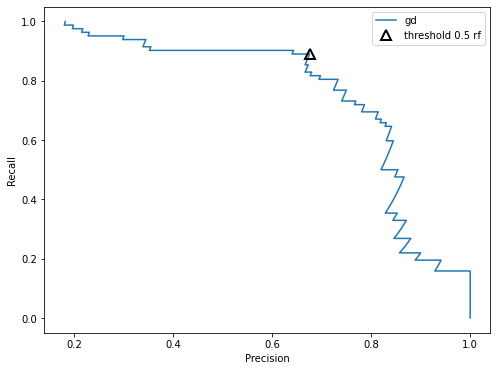

In [35]:
fig= plt.subplots(figsize=(8, 6))
precision_gd, recall_gd, thresholds_gd = precision_recall_curve(y_val, gradient_sm.predict_proba(X_val)[:, 1])
plt.plot(precision_gd, recall_gd, label="gd")

close_default_gd = np.argmin(np.abs(thresholds_gd - 0.4))
plt.plot(precision_gd[close_default_gd], recall_gd[close_default_gd], '^', c='k', markersize=10, label='threshold 0.5 rf', fillstyle="none", mew=2)
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.legend(loc="best")

<a id="6"></a>
# 6. final test

In [36]:
print("Random Forest final test score: {:.2f}".format(forest_ds.score(X_test, y_test)))
foresttest_crossval = cross_val_score(forest_ds, df_train1, label)
print("Random Forest final cross-validation test score: {:.2f}".format(foresttest_crossval.mean()))

test_forest = forest_ds.predict(X_test)
confusion_foresttest=confusion_matrix(y_test, test_forest)
print("\nconfusion matrix:\n{}".format(confusion_foresttest))

foresttest_proba = forest_ds.predict_proba(X_test)

foresttest = (foresttest_proba [:,1] >= 0.56).astype('int')

forestaccuracy_test = accuracy_score(y_test, foresttest)
#test_crossval2 = cross_val_score(test, df_train1, label)
print("\naccurcy rate with test data with 0.56 threshold is {}".format(str(round(forestaccuracy_test,4,)*100))+"%")
#print("cross-validation rate with test data is {}".format(str(round(test_crossval2,4,)*100))+"%")
      
print("\nrandom forest classification report with adjuested threshold\n")
print(classification_report(y_test, foresttest, target_names = ["Stay", "Churn"]))

Random Forest final test score: 0.90
Random Forest final cross-validation test score: 0.94

confusion matrix:
[[507  62]
 [  2  96]]

accurcy rate with test data with 0.56 threshold is 91.75%

random forest classification report with adjuested threshold

              precision    recall  f1-score   support

        Stay       1.00      0.91      0.95       569
       Churn       0.64      0.98      0.78        98

    accuracy                           0.92       667
   macro avg       0.82      0.94      0.86       667
weighted avg       0.94      0.92      0.92       667



In [37]:
print("Random Forest final test score: {:.2f}".format(forest_sm.score(X_test, y_test)))
forestsmtest_crossval = cross_val_score(forest_sm, df_train1, label)
print("Random Forest final cross-validation test score for smote: {:.2f}".format(forestsmtest_crossval.mean()))

test_forestsm = forest_sm.predict(X_test)
confusion_forestsmtest=confusion_matrix(y_test, test_forestsm)
print("\nconfusion matrix:\n{}".format(confusion_forestsmtest))

forestsmtest_proba = forest_sm.predict_proba(X_test)

forestsmtest = (forestsmtest_proba [:,1] >= 0.56).astype('int')

forestsmaccuracy_test = accuracy_score(y_test, forestsmtest)
#test_crossval2 = cross_val_score(test, df_train1, label)
print("\naccurcy rate with test data with 0.56 threshold is {}".format(str(round(forestsmaccuracy_test,4,)*100))+"%")
#print("cross-validation rate with test data is {}".format(str(round(test_crossval2,4,)*100))+"%")
      
print("\nrandom forest classification report with adjuested threshold\n")
print(classification_report(y_test, forestsmtest, target_names = ["Stay", "Churn"]))

Random Forest final test score: 0.89
Random Forest final cross-validation test score for smote: 0.94

confusion matrix:
[[520  49]
 [ 23  75]]

accurcy rate with test data with 0.56 threshold is 90.25%

random forest classification report with adjuested threshold

              precision    recall  f1-score   support

        Stay       0.95      0.93      0.94       569
       Churn       0.65      0.74      0.69        98

    accuracy                           0.90       667
   macro avg       0.80      0.84      0.82       667
weighted avg       0.91      0.90      0.91       667



In [38]:
print("Gradient Boosting final test score: {:.2f}".format(gradient_sm.score(X_test, y_test)))
gdtest_crossval = cross_val_score(gradient_sm, df_train1, label)
print("Gradient Boosting final cross-validation test score: {:.2f}".format(gdtest_crossval.mean()))

test_gd = gradient_sm.predict(X_test)
gdconfusion_test=confusion_matrix(y_test, test_gd)
print("\nconfusion matrix:\n{}".format(gdconfusion_test))

test_gd_original = gradient.predict(X_test)
gdoconfusion_test=confusion_matrix(y_test, test_gd_original)
print("\nconfusion matrix without sm:\n{}".format(gdoconfusion_test))

gdtest_proba = gradient_sm.predict_proba(X_test)

gdtest = (gdtest_proba [:,1] >= 0.38).astype('int')

gdconfusion_test2=confusion_matrix(y_test, gdtest)
print("\nconfusion matrix with 0.38 threshold:\n{}".format(gdconfusion_test2))

gdaccuracy_test = accuracy_score(y_test, gdtest)
print("\naccurcy rate with test data with 0.38 threshold is {}".format(str(round(gdaccuracy_test,4,)*100))+"%")

      
print("\ngradient boost classification report with adjuested threshold\n")
print(classification_report(y_test, gdtest, target_names = ["Stay", "Churn"]))

test_gdo = gradient.predict(X_test)
print("\ngradient boost classification report original\n")
print(classification_report(y_test, test_gdo, target_names = ["Stay", "Churn"]))

Gradient Boosting final test score: 0.89
Gradient Boosting final cross-validation test score: 0.94

confusion matrix:
[[520  49]
 [ 24  74]]

confusion matrix without sm:
[[558  11]
 [ 31  67]]

confusion matrix with 0.38 threshold:
[[507  62]
 [ 20  78]]

accurcy rate with test data with 0.38 threshold is 87.71%

gradient boost classification report with adjuested threshold

              precision    recall  f1-score   support

        Stay       0.96      0.89      0.93       569
       Churn       0.56      0.80      0.66        98

    accuracy                           0.88       667
   macro avg       0.76      0.84      0.79       667
weighted avg       0.90      0.88      0.89       667


gradient boost classification report original

              precision    recall  f1-score   support

        Stay       0.95      0.98      0.96       569
       Churn       0.86      0.68      0.76        98

    accuracy                           0.94       667
   macro avg       0.90     